# Gaussian Mixture Model Animation

This notebook contains an implementation and animation of a [Gaussian Mixture Model (GMM)](https://en.wikipedia.org/wiki/Mixture_model) fit to a dataset of earthquake locations near Fiji. The goal of the GMM is fit `k` components each with a mean and variance to a dataset (2 means and a covariance matrix in this case since the dataset is 2-dimensional). The GMM can be fit to a dataset using an [expectation-maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM) algorithm. This works calculating a responsibilites for each model component to each data point called a responsibilites matrix (expectation) and then generating a model of weights, means, and variances for each component based on the current responsibilities matrix (maximization). This feedback loop repeats until the model is stable and correctly fit to the dataset.

## Implementation

Let's start with the implementation of the GMM using NumPy.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gaussian mixture model using expectation/maximization algorithm
class GMM:
    # Initialize with n_comps components and X data using given model or
    # a random model if none is given
    def __init__(self, X, n_comps, init_model=None):
        if init_model is None:
            resp = self._get_rand_resp(X, n_comps)
            model = self._get_model(X, resp)
        else:
            model = init_model
            n_dims = X.shape[1]
            assert model[0].shape == (n_comps,), f'model must have {n_comps} weights'
            assert model[1].shape == (n_comps, n_dims), f'model must have {n_comps}x{n_dims} means'
            assert model[2].shape == (n_comps, n_dims, n_dims), f'model must {n_comps}x{n_dims} covariance matrices' 
        
        self.init_model = model
        self.model = model
        self.resp = resp if init_model is None else None
        self.X = X
        self.n_comps = n_comps
        self.n_iters = 0
        self.levels = np.arange(0, 0.05, 0.001)
    
    # Revert GMM to initial model
    def reinit(self):
        self.model = self.init_model
        self.resp = None
        self.n_iters = 0
    
    # Perform n_inits initializations of n_iters iterations saving the 
    # model with the lowest weighted mean distance (best fit)
    def multi_init(self, n_inits, n_iters):
        self.fit(n_iters)
        for _ in range(n_inits):
            gmm = GMM(self.X, self.n_comps)
            gmm.fit(n_iters)
            if gmm.weighted_mean_dist < self.weighted_mean_dist:
                self.init_model = gmm.init_model
                self.model = gmm.model
                self.resp = gmm.resp
                self.n_iters = gmm.n_iters   
    
    # Step through n_iters iterations of EM algorithm to fit GMM to points
    def fit(self, n_iters):
        model, X = self.model, self.X
        
        for _ in range(n_iters):
            resp = self._get_resp(X, model)  # 1. expectation
            model = self._get_model(X, resp) # 2. maximization
        
        self.model = model
        self.resp = resp
        self.X = X
        self.n_iters += n_iters
    
    # Return model estimation given current responsibilities
    def _get_model(self, X, resp):
        nk = resp.sum(axis=0)
        weights = nk / X.shape[0]
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covs = self._get_covs(X, resp, nk, means)
        return (weights, means, covs)
    
    # Return covariance matrix given current responsibilities
    def _get_covs(self, X, resp, nk, means):
        n_comps, n_dims = means.shape
        covs = np.empty((n_comps, n_dims, n_dims))
        for k in range(means.shape[0]):
            diff = X - means[k]
            covs[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        return covs
    
    # Return responsibilities matrix for points given current model
    def _get_resp(self, X, model):
        weights, means, covs = model
        n_comps = weights.shape[0]
        n_items = X.shape[0]
        resp = np.empty((n_items, n_comps))
        for k in range(n_comps):
            resp[:, k] = stats.multivariate_normal.pdf(X, mean=means[k], cov=covs[k], allow_singular=True)
        resp = resp * weights    
        return resp / resp.sum(axis=1)[:, np.newaxis]
    
    # Return random responsibilities matrix for random initialization
    def _get_rand_resp(self, X, k):
        resp = np.random.rand(X.shape[0], k)
        return resp / resp.sum(axis=1)[:, np.newaxis]
    
    # Return tuple of:
    # - mesh of x coordinates
    # - mesh of y coordinates
    # - mesh of joint probabilities for each (x, y) coordinate
    def _get_mesh_joint_p(self, density):
        weights, means, covs = self.model
        n_comps = weights.shape[0]
        
        x_pts = np.linspace(np.min(self.X[:, 0]), np.max(self.X[:, 0]), density)
        y_pts = np.linspace(np.min(self.X[:, 1]), np.max(self.X[:, 1]), density)
        x_mesh, y_mesh = np.meshgrid(x_pts, y_pts)
        mesh = np.stack((x_mesh, y_mesh), axis=2) # https://stackoverflow.com/a/56403961
        
        mesh_p = np.empty((n_comps, density, density))
        for k in range(n_comps):
            mesh_p[k] = stats.multivariate_normal.pdf(mesh, mean=means[k], cov=covs[k], allow_singular=True)
        mesh_joint_p = np.sum(mesh_p * weights[:, np.newaxis, np.newaxis], axis=0)
        
        return (x_mesh, y_mesh, mesh_joint_p)
    
    # Return weighted mean distance from points to GMM clusters
    @property
    def weighted_mean_dist(self):
        _, means, _ = self.model
        return np.sqrt(
            np.sum(
                np.sum(
                    np.sum((
                        np.array((self.X,) * self.n_comps) - \
                        means[:, np.newaxis]
                    ) ** 2, axis=2) * self.resp.T
                , axis=1)
            , axis=0) / self.X.shape[0])
    
    # Return list cluster point assignments based on highest responsibility
    def get_hard_clusters(self):
        hard_clusters = [ [] for _ in range(self.n_comps) ]
        
        for point_idx, point_resps in enumerate(self.resp):
            hard_clusters[np.argmax(point_resps)].append(self.X[point_idx])
        
        return [ np.array(cluster) for cluster in hard_clusters ]
    
    # Return n_samples samples from current model
    def sample(self, n_samples):
        weights, means, covs = self.model
        n_dims = means.shape[1]
        sample_points = np.empty((n_samples, n_dims))
        for point_idx in range(n_samples):
            comp_idx = np.random.choice(range(self.n_comps), p=weights)
            mean, cov = means[comp_idx], covs[comp_idx]
            sample_points[point_idx] = stats.multivariate_normal.rvs(mean=mean, cov=cov)
        return sample_points
    
    # Print current model information
    def print_model(self):
        weights, means, covs = self.model
        print(f'{self.n_iters} iterations:')
        print('weights:\n', weights)
        print('means:\n', means)
        print('covs:\n', covs)
    
    # Plot scatter of X and GMM contours in 2D
    def plot_2d(self, plot_info, density=500):
        assert self.X.shape[1] == 2, 'data must be 2 dimensional to plot 2D'
        title, x_label, y_label, pt_color = plot_info
        plt.scatter(self.X[:, 0], self.X[:, 1], c=pt_color, marker='.')
        plt.contour(*self._get_mesh_joint_p(density), levels=self.levels)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.show()

## Dataset

Next we load the dataset we want to fit the GMM to. I've picked a dataset of coordinates for earthquakes near Fiji from the Rdatasets project. Here is [some documentation](https://vincentarelbundock.github.io/Rdatasets/doc/datasets/quakes.html) on the dataset and here is [the raw source](https://vincentarelbundock.github.io/Rdatasets/csv/openintro/earthquakes.csv).

     lat    long  depth  mag  stations
0 -20.42  181.62    562  4.8        41
1 -20.62  181.03    650  4.2        15
2 -26.00  184.10     42  5.4        43
3 -17.97  181.66    626  4.1        19


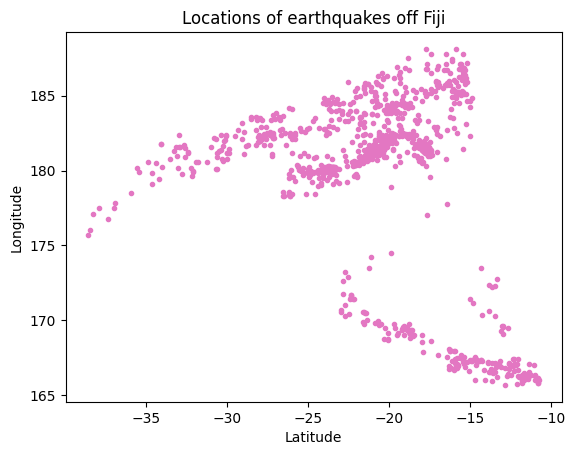

In [2]:
import statsmodels.api as sm

df = sm.datasets.get_rdataset('quakes').data
print(df.head(4))
plt.scatter(df['lat'], df['long'], c='tab:pink', marker='.')
plt.title('Locations of earthquakes off Fiji')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

## Execution

Now it's time to fit the GMM to our dataset. Because the final model after fitting is heavily dependent on random initialization of the responsibilities matrix we perform 200 fits for each `k` value (number of components in model) and pick the initialization with the lowest total mean distance from each point to each component, weighted by each component's responsibity to that point.

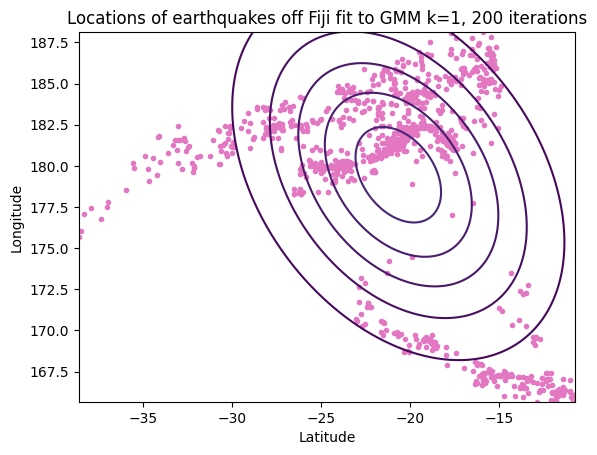

200 iterations:
weights:
 [1.]
means:
 [[-20.64275 179.46202]]
covs:
 [[[ 25.26344894 -11.11557025]
  [-11.11557025  36.80195232]]]


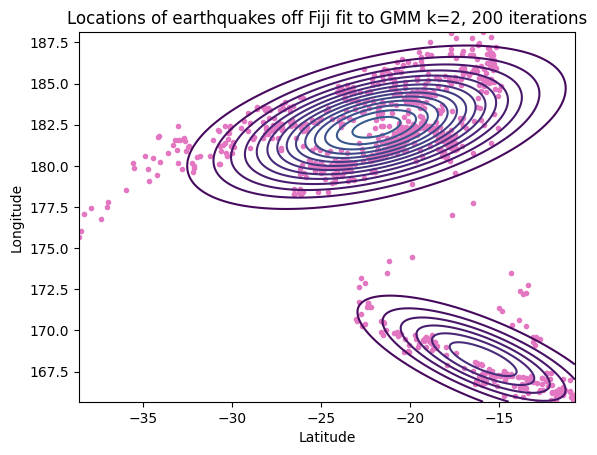

200 iterations:
weights:
 [0.79510817 0.20489183]
means:
 [[-21.87119236 182.34955461]
 [-15.87562713 168.25658396]]
covs:
 [[[21.07717005  4.68305741]
  [ 4.68305741  4.59613681]]

 [[12.92722708 -5.24118085]
  [-5.24118085  3.86273084]]]


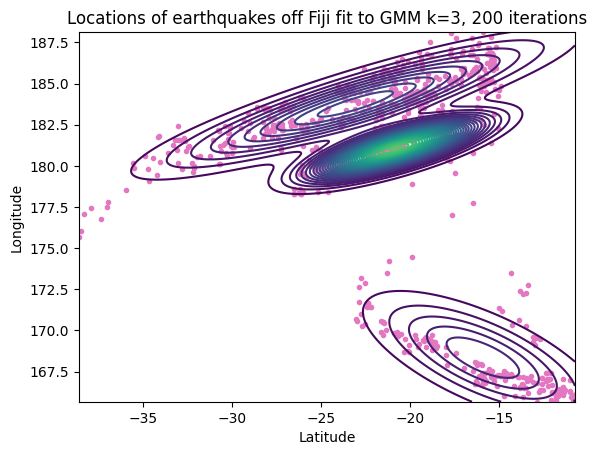

200 iterations:
weights:
 [0.41083555 0.38217123 0.20699322]
means:
 [[-20.79000427 181.05827935]
 [-23.05911083 183.76581325]
 [-15.88916016 168.34771391]]
covs:
 [[[ 7.05018568  2.06782524]
  [ 2.06782524  1.06678195]]

 [[33.47996655 10.8309566 ]
  [10.8309566   4.4700699 ]]

 [[12.82276669 -5.30151736]
  [-5.30151736  4.63920993]]]


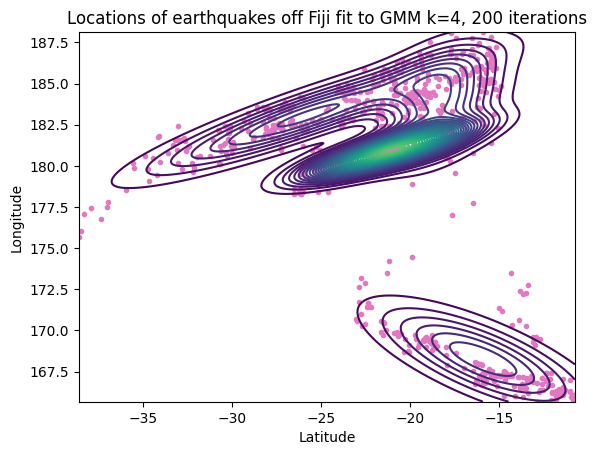

200 iterations:
weights:
 [0.20498146 0.32977734 0.21989229 0.24534891]
means:
 [[-15.87746885 168.25925103]
 [-21.26450118 180.86691715]
 [-18.38263085 183.81036888]
 [-25.81390676 183.03606626]]
covs:
 [[[12.9298222  -5.25012822]
  [-5.25012822  3.87732837]]

 [[ 7.04733412  2.06146857]
  [ 2.06146857  0.92992534]]

 [[ 4.1805541   1.66645584]
  [ 1.66645584  4.20104154]]

 [[28.13743032 10.2656873 ]
  [10.2656873   4.51785085]]]


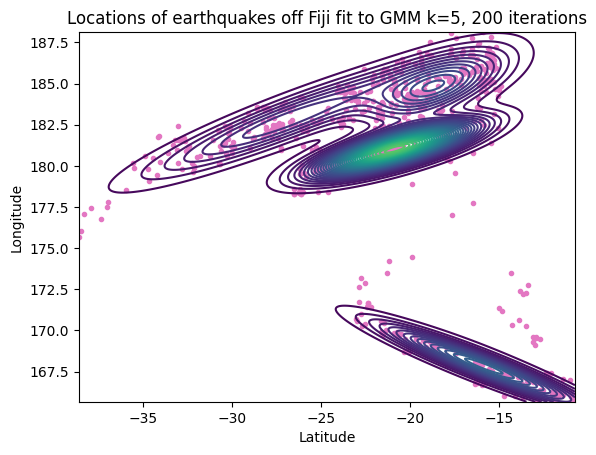

200 iterations:
weights:
 [0.18681036 0.17745716 0.20470384 0.40097018 0.03005846]
means:
 [[-18.53477499 184.82523685]
 [-15.82522699 167.82654037]
 [-26.96056748 182.76784178]
 [-20.85354481 181.01363795]
 [-16.34750621 171.61157749]]
covs:
 [[[ 6.0774222   2.18545518]
  [ 2.18545518  1.83157599]]

 [[12.52061481 -5.20323682]
  [-5.20323682  2.42658861]]

 [[23.97642886  9.74402657]
  [ 9.74402657  4.66891423]]

 [[ 7.14565473  2.01803091]
  [ 2.01803091  0.99312313]]

 [[14.68077795 -4.95711583]
  [-4.95711583  7.38346725]]]


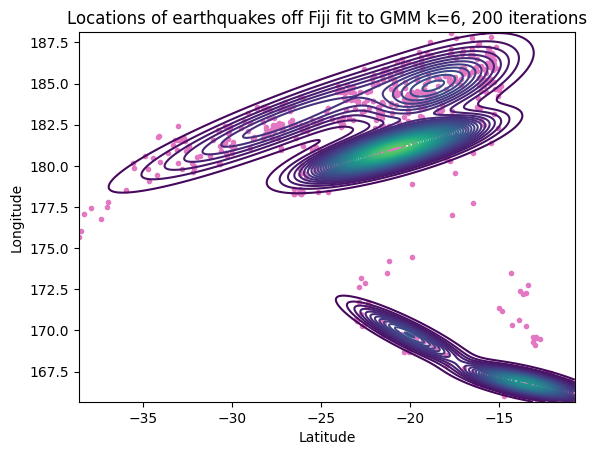

200 iterations:
weights:
 [0.02604171 0.20475057 0.40081769 0.11566535 0.0658674  0.18685728]
means:
 [[-15.91253125 171.90841443]
 [-26.95935425 182.76824437]
 [-20.85421637 181.01353837]
 [-13.5525781  166.8160542 ]
 [-20.02089785 169.7248763 ]
 [-18.53494998 184.8240905 ]]
covs:
 [[[12.55750261 -5.19694592]
  [-5.19694592  7.26934902]]

 [[23.97919413  9.74474412]
  [ 9.74474412  4.66908962]]

 [[ 7.14781903  2.01958939]
  [ 2.01958939  0.99257716]]

 [[ 3.12563049 -0.7025705 ]
  [-0.7025705   0.32408429]]

 [[ 3.4094904  -1.76972519]
  [-1.76972519  1.13929932]]

 [[ 6.07602494  2.18678553]
  [ 2.18678553  1.83377891]]]


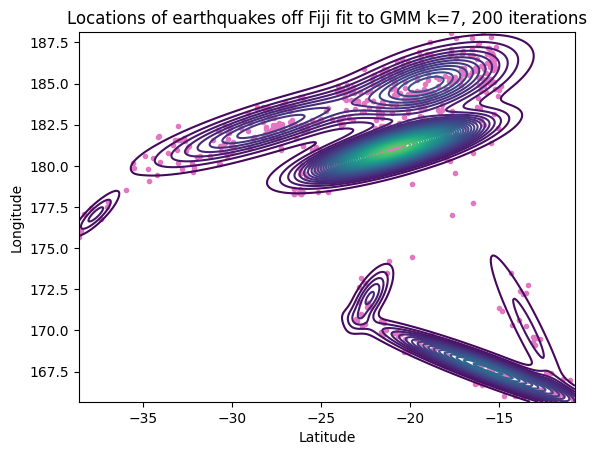

200 iterations:
weights:
 [0.02901455 0.01919194 0.22255811 0.15964735 0.40310277 0.00758828
 0.15889701]
means:
 [[-13.32671223 170.13332377]
 [-22.24486811 171.98384798]
 [-18.88890763 184.98794844]
 [-15.59963975 167.64769641]
 [-20.85783502 181.02166277]
 [-37.64451998 177.04987803]
 [-27.95100121 182.35748956]]
covs:
 [[[ 2.70843439 -5.27720379]
  [-5.27720379 11.77819386]]

 [[ 0.52573332  0.58107289]
  [ 0.58107289  1.28219081]]

 [[ 6.81749556  1.96403764]
  [ 1.96403764  1.77745502]]

 [[ 9.95124949 -3.93696224]
  [-3.93696224  1.76762921]]

 [[ 7.10471167  2.02369698]
  [ 2.02369698  1.00169744]]

 [[ 0.64268786  0.57521658]
  [ 0.57521658  0.70853722]]

 [[13.55572492  4.33846885]
  [ 4.33846885  1.97773734]]]


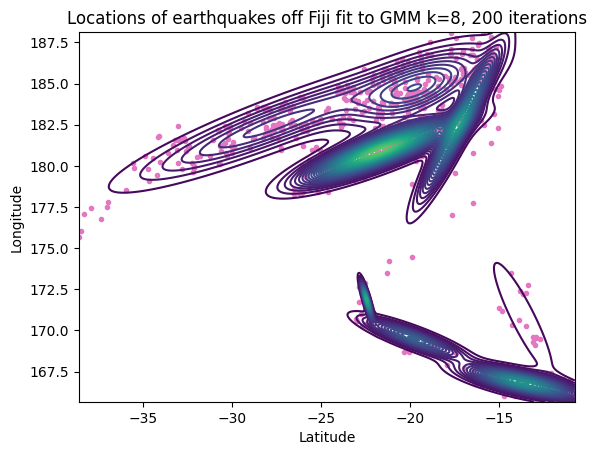

200 iterations:
weights:
 [0.16886331 0.13022122 0.18361415 0.0547178  0.3131953  0.01195338
 0.02193914 0.1154957 ]
means:
 [[-19.53195192 184.70206176]
 [-17.25993523 182.42342213]
 [-27.6534223  182.4892501 ]
 [-19.78014357 169.51413627]
 [-21.68228442 180.92413262]
 [-22.42472553 171.8599607 ]
 [-13.6333265  170.78637952]
 [-13.67219907 166.83189912]]
covs:
 [[[ 5.89757733  2.29332445]
  [ 2.29332445  2.04465807]]

 [[ 1.38074737  2.63535067]
  [ 2.63535067  5.69539993]]

 [[21.29905349  8.63240699]
  [ 8.63240699  4.21544378]]

 [[ 2.53423976 -0.98154405]
  [-0.98154405  0.50808557]]

 [[ 5.69543928  2.20428245]
  [ 2.20428245  1.17805903]]

 [[ 0.0369037  -0.10358063]
  [-0.10358063  0.39531868]]

 [[ 2.09365331 -3.83011455]
  [-3.83011455  8.62813502]]

 [[ 3.27490576 -0.75444397]
  [-0.75444397  0.33323349]]]


In [3]:
# Fit earthquake data GMMs for k=[1..9] using multiple initializations
data = np.array(df.loc[:, ['lat', 'long']])
best_gmms = {}
n_inits, n_iters = 100, 200
const_plot_info = ['Latitude', 'Longitude', 'tab:pink']
np.random.seed(777)
for k in range(1, 9):
    gmm = GMM(data, k)
    gmm.multi_init(n_inits, n_iters)
    title = f'Locations of earthquakes off Fiji fit to GMM k={k}, {n_iters} iterations'
    plot_info = [title, *const_plot_info]
    gmm.plot_2d(plot_info)
    gmm.print_model()
    best_gmms[k] = gmm

## Sampling

A useful property of GMMs is ability to generate sample datasets from the model. Let's generate 1000 data points for best GMM from each `k` value.

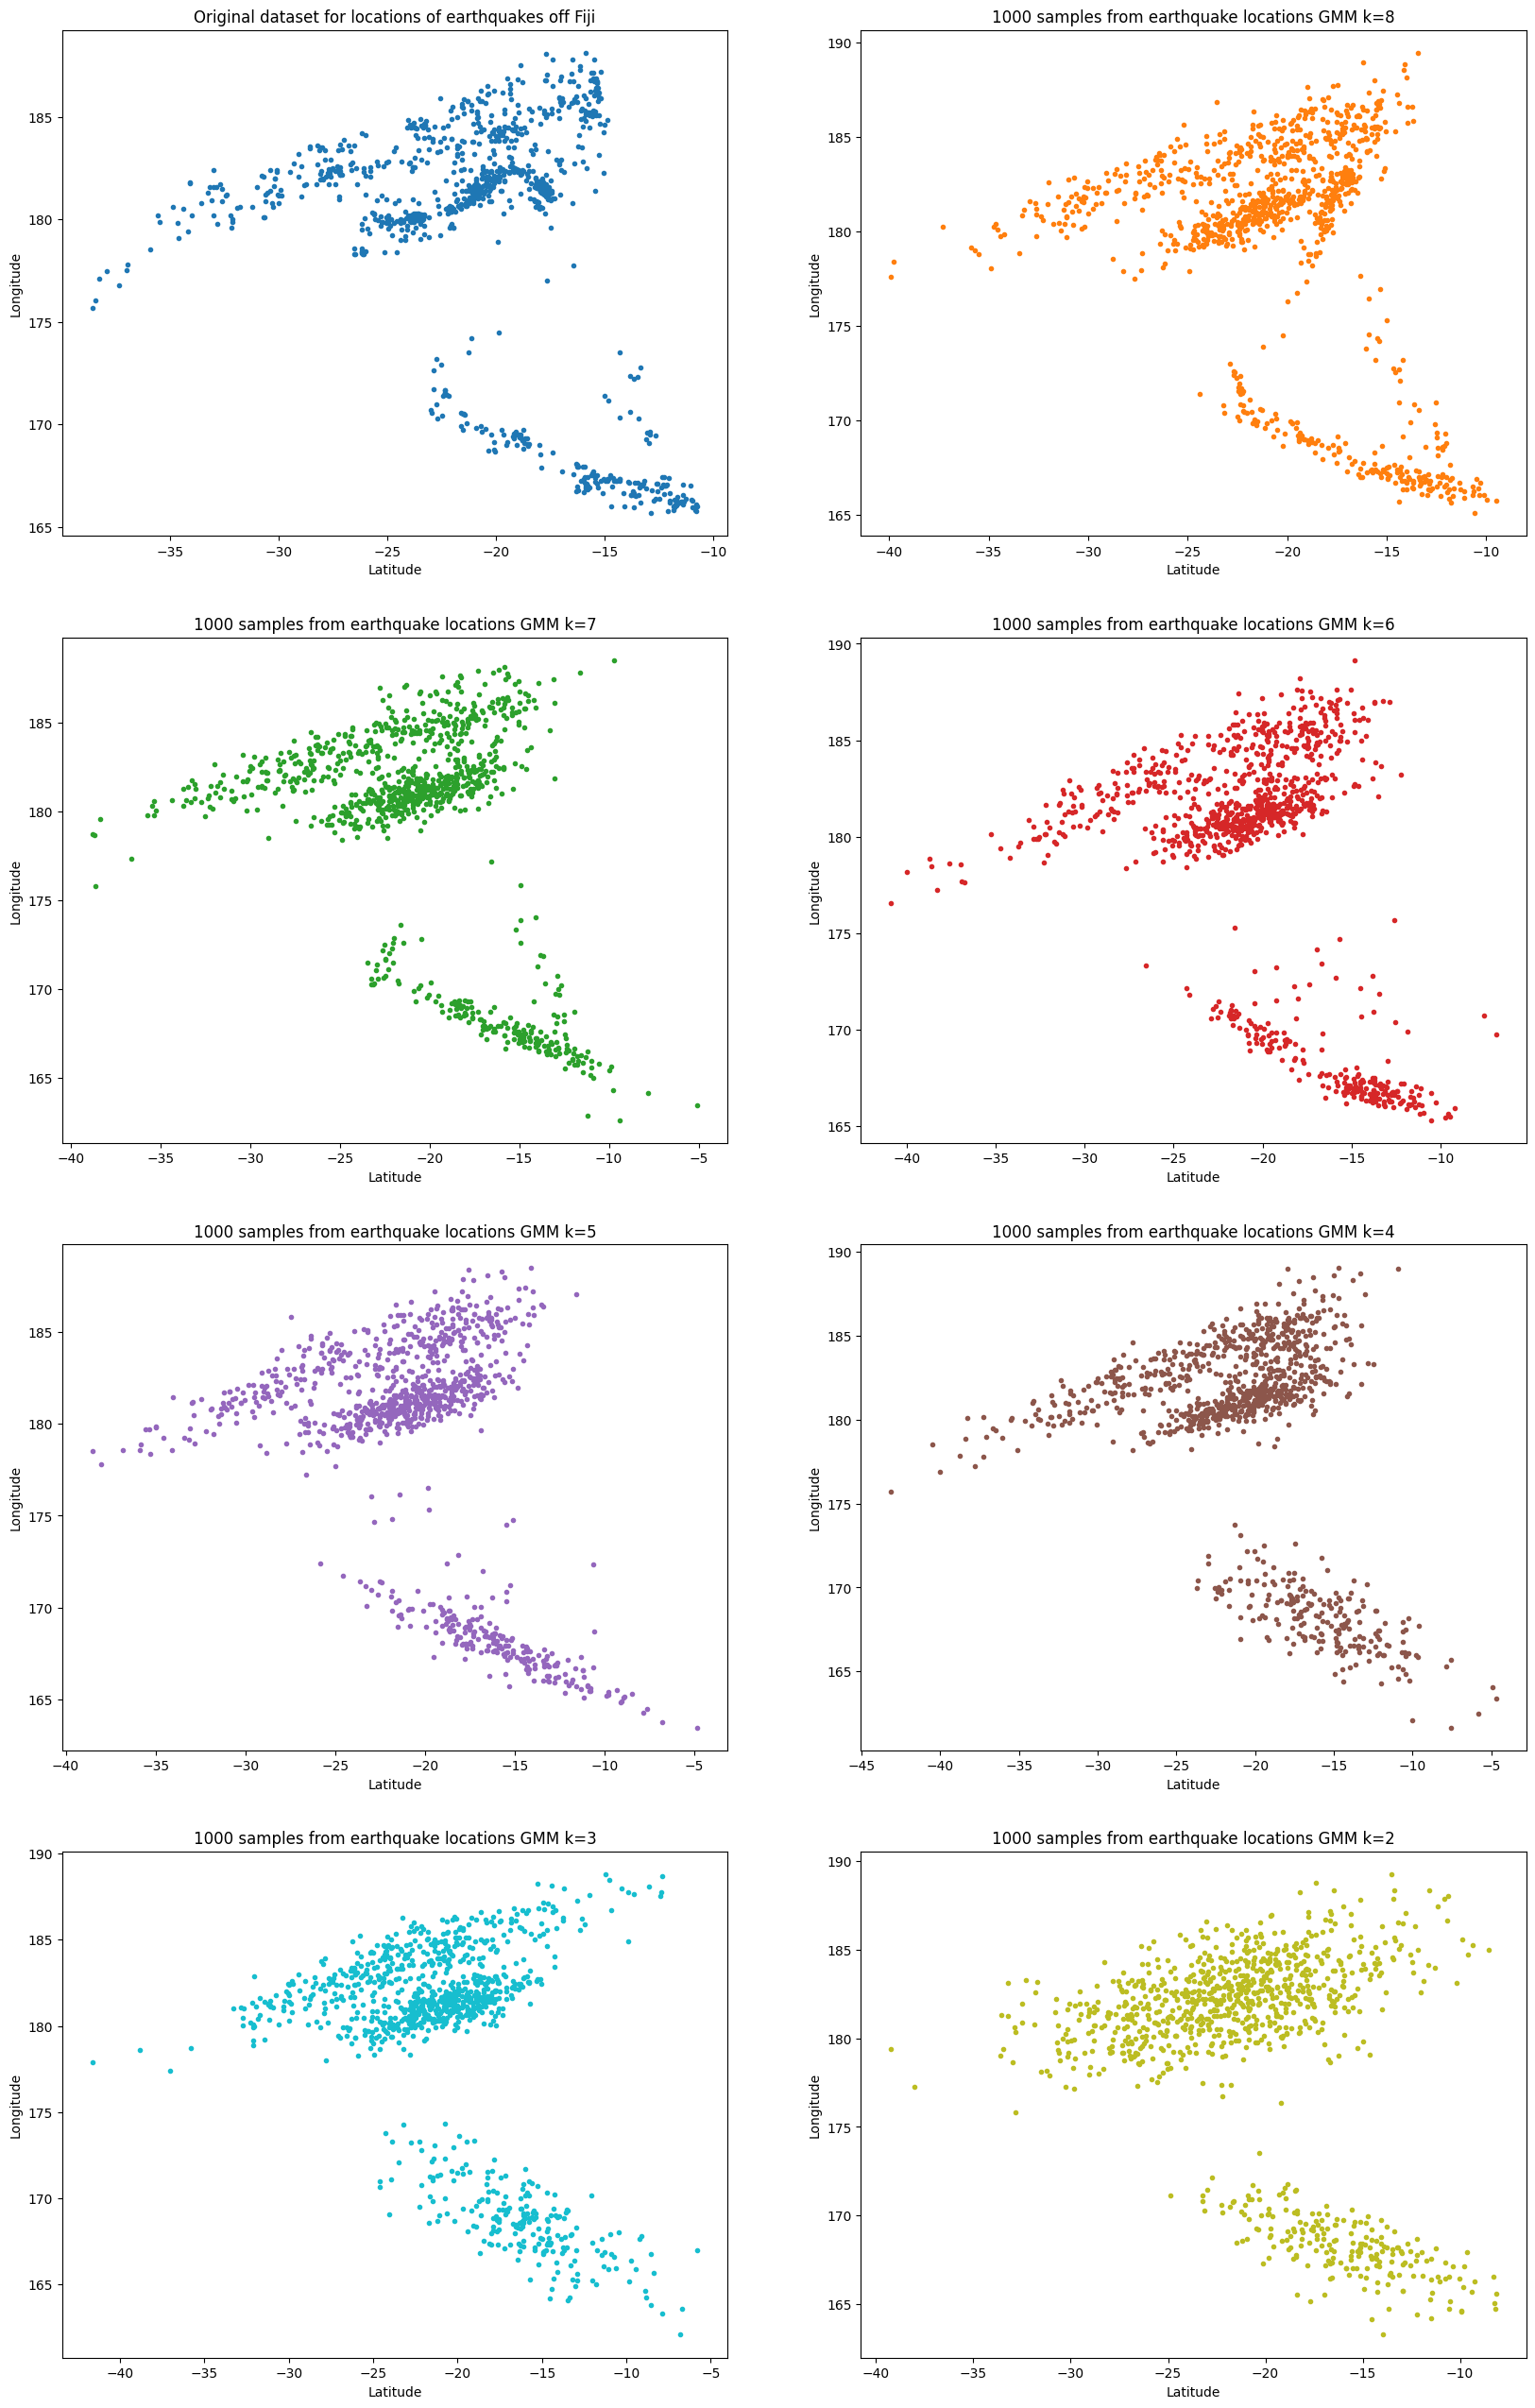

In [4]:
# Plot 1000 sampled data points from each GMM
row_n, col_n = 4, 2
row_idx, col_idx = 0, 0
fig, axs = plt.subplots(row_n, col_n, figsize=[20, 32])
point_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:cyan', 'tab:olive']

def plot_dataset(X, plot_info, row_idx, col_idx):
    title, x_label, y_label = plot_info
    axs[row_idx, col_idx].scatter(X[:, 0], X[:, 1], marker='.', c=point_colors[row_idx * col_n + col_idx])
    axs[row_idx, col_idx].set_xlabel(x_label)
    axs[row_idx, col_idx].set_ylabel(y_label)
    axs[row_idx, col_idx].set_title(title)

const_plot_info = ['Latitude', 'Longitude']
plot_info = ['Original dataset for locations of earthquakes off Fiji', *const_plot_info]
plot_dataset(data, plot_info, row_idx, col_idx)
col_idx += 1

n_samples = 1000
for k in range(8, 1, -1):
    sampled_data = best_gmms[k].sample(n_samples)
    plot_info = [f'{n_samples} samples from earthquake locations GMM k={k}', *const_plot_info]
    plot_dataset(sampled_data, plot_info, row_idx, col_idx)
    
    col_idx += 1
    if col_idx >= col_n:
        row_idx += 1
        col_idx = 0
        
plt.show()

## Animations

Finally, let's reinitialize the best GMMs and animate the EM algorithm using Matplotlib.

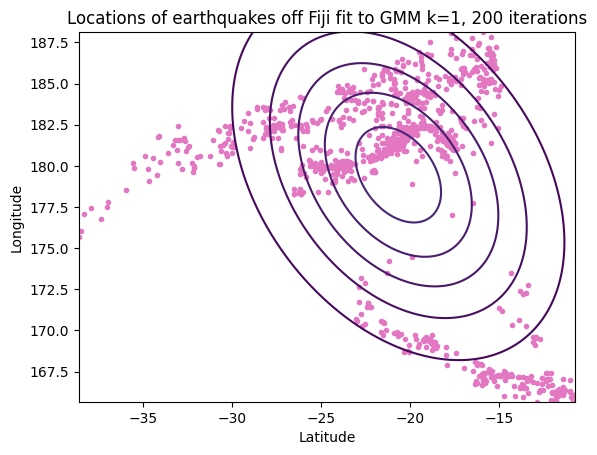

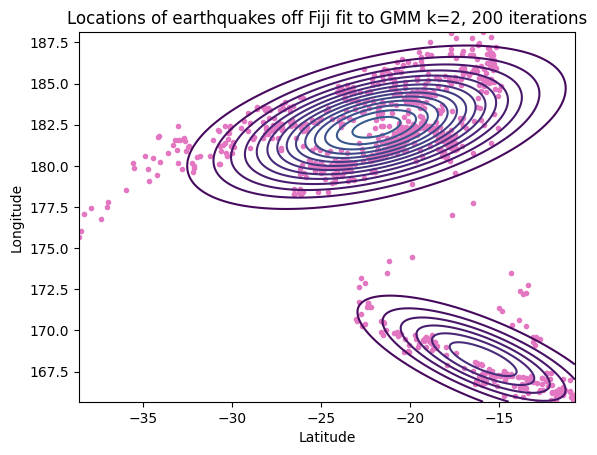

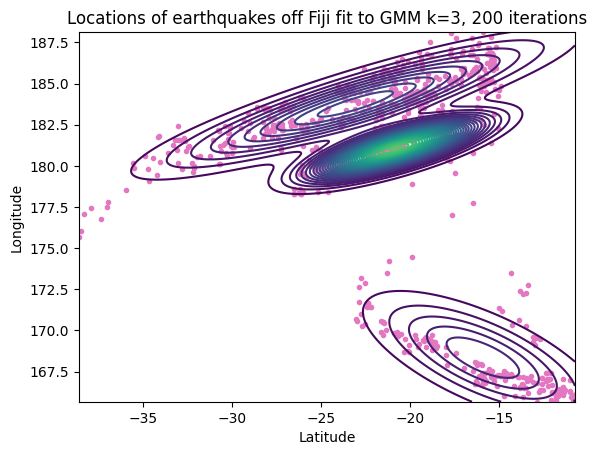

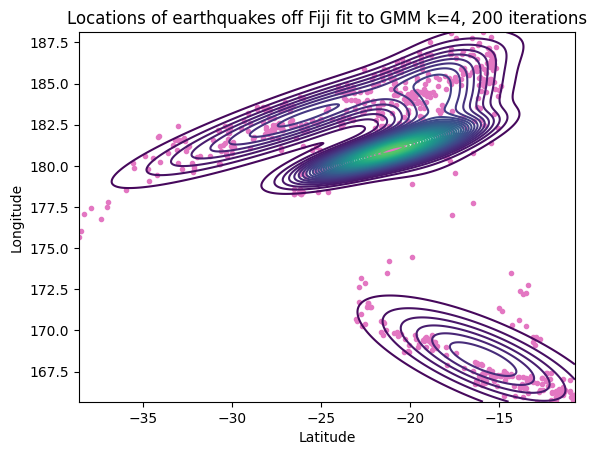

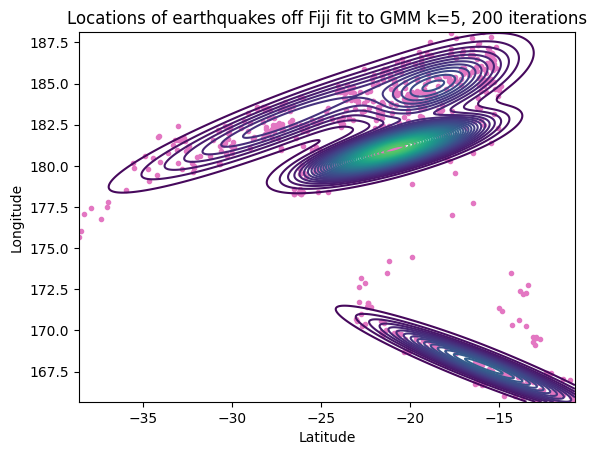

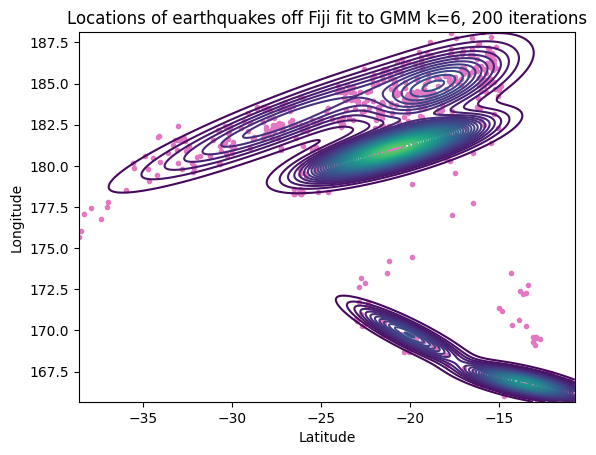

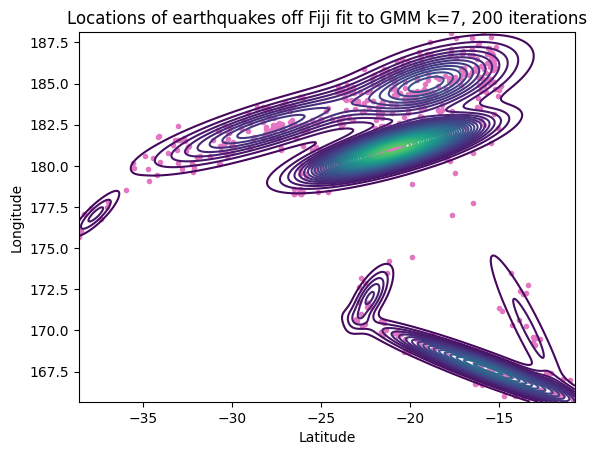

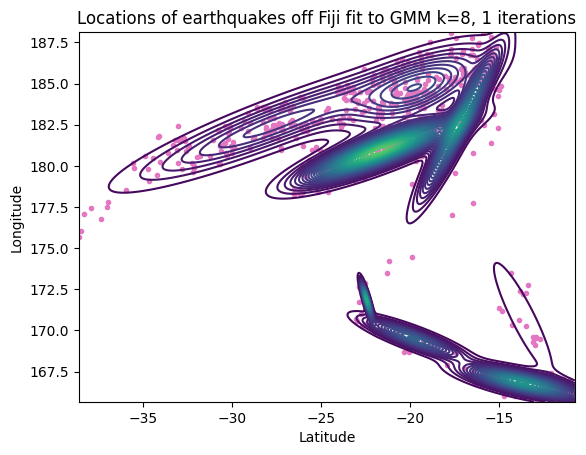

In [5]:
from matplotlib import animation

data = np.array(df.loc[:, ['lat', 'long']])
n_iters, interval, density = 200, 25, 500

for k, gmm in best_gmms.items():
    gmm.reinit()
    fig, ax = plt.subplots()

    def plot_gmm(n):
        ax.clear()
        ax.scatter(data[:, 0], data[:, 1], c='tab:pink', marker='.')
        ax.contour(*gmm._get_mesh_joint_p(density), levels=gmm.levels)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_title(f'Locations of earthquakes off Fiji fit to GMM k={k}, {n} iterations')

    plot_gmm(0)

    def draw(n):
        gmm.fit(1)
        plot_gmm(n + 1)
        
    ani = animation.FuncAnimation(fig, draw, n_iters, interval=interval, repeat=False, blit=False)
    ani.save(f'gmm_{k}.mp4')